# Discrete-time LQ-optimal control on a fixed time horizon with fixed final states

The goal is to find a sequence $\mathbf{u}_{0},\ldots,\mathbf{u}_{N-1}$ that yields the minimum in the following problem

\begin{align*}
\min_{\mathbf{x}_{1},\ldots,\mathbf{x}_{N},\mathbf{u}_{0},\ldots,\mathbf{u}_{N-1}} &\; \frac{1}{2}\sum_{k=0}^{N-1}\left[\mathbf x_k^T \mathbf Q \mathbf x_k+\mathbf u_k^T \mathbf R\mathbf u_k\right]\\
\text{s.t. } &\; \mathbf x_{k+1} = \mathbf A \mathbf x_{k} + \mathbf B \mathbf u_k,\\
& \mathbf x_0 = \mathbf r_0,\\
& \mathbf x_N = \mathbf r_N,\\
& \mathbf Q\geq 0, \mathbf R>0.
\end{align*}

where $\mathbf r_0$ and $\mathbf r_N$ denote the desired values of the initial and final states, respectively. Note the the final state is not penalized (the corresponding term is missing in the cost function) because it is fixed and not subject to optimization.

## Two-point boundary value problem (assuming A nonsingular)

We need to solve the following "weird" discrete-time system. It is weird in the sense that from the perspective of the states the time evolves forward but from the perspective of the costate it evolves backward

\begin{align*}
 \mathbf x_{k+1} &=\mathbf A\mathbf x_k-\mathbf B\mathbf R^{-1}\mathbf B^T\boldsymbol\lambda_{k+1},\\
 \boldsymbol\lambda_k &= \mathbf Q\mathbf x_k+\mathbf A^T\boldsymbol\lambda_{k+1}.
\end{align*}

It is a two-point boundary value problem because the state is specified on both ends of the time interval (the costate is not specified at all)

\begin{align*}
 \mathbf x_0 &= \mathbf r_0,\\
 \mathbf x_N &= \mathbf r_N.
\end{align*}

Once the states and costates are obtained, the optimal control sequence is given by

$$\mathbf u_k = -\mathbf R^{-1}\mathbf B^T\boldsymbol\lambda_{k+1}.$$

This assumes, of course, that $\mathbf R$ is nonsigular but we did include this assumption in the original problem formulation.

There is not much we can do with these equations in this form. However, assuming that $\mathbf A$ is nonsingular, we can turn these into the discrete-time Hamiltonian system, in which we reorganized the equations so that both state and co-state variables evolve backwards in time

\begin{equation}
\begin{bmatrix}
 \mathbf x_{k}\\\boldsymbol\lambda_k
\end{bmatrix}
=\underbrace{
\begin{bmatrix}
 \mathbf A^{-1} & \mathbf A^{-1}\mathbf B\mathbf R^{-1}\mathbf B^T\\\mathbf Q\mathbf A^{-1} & \mathbf A^T+\mathbf Q\mathbf A^{-1}\mathbf B\mathbf R^{-1}\mathbf B^T
\end{bmatrix}}_{\mathbf H}
\begin{bmatrix}
 \mathbf x_{k+1} \\ \boldsymbol\lambda_{k+1}
\end{bmatrix}
\end{equation}

Extending this onto the whole time interval [0,N] we get

\begin{equation}
\begin{bmatrix}
 \mathbf x_{0}\\\boldsymbol\lambda_0
\end{bmatrix}
=\underbrace{
\begin{bmatrix}
 \mathbf A^{-1} & \mathbf A^{-1}\mathbf B\mathbf R^{-1}\mathbf B^T\\\mathbf Q\mathbf A^{-1} & \mathbf A^T+\mathbf Q\mathbf A^{-1}\mathbf B\mathbf R^{-1}\mathbf B^T
\end{bmatrix}^N}_{\mathbf M:=\mathbf H^N}
\begin{bmatrix}
 \mathbf x_{N} \\ \boldsymbol\lambda_{N}
\end{bmatrix}
\end{equation}

From the first equation we can get $\boldsymbol \lambda_N$. Namely from

$$
\mathbf M_{12}\boldsymbol \lambda_N = \mathbf x_0-\mathbf M_{11}\mathbf x_N,
$$

we can get (after substituting for the known initial and final states)

$$
\boldsymbol \lambda_N = \mathbf M_{12}^{-1}(\mathbf r_0-\mathbf M_{11}\mathbf r_N).
$$

Having the final state and the co-state $[\mathbf x_N, \boldsymbol \lambda_N]^T$, we could solve the Hamiltonian system backward to get the states and co-states on the whole time interval $[0,N-1]$.

Below is the implementation of the algorithm and then it is used for a concrete model.

In [1]:
using LinearAlgebra

### Implementation of the algorithm in Julia

In [2]:
function dlqr_fixed_final_state_bvp(A,B,Q,R,N,r0,rN)
    n = size(A,1)
    m = size(B,2)

    H = [inv(A) A\B/R*B'; Q/A A'+Q/A*B/R*B']    # discrete-time Hamiltonian matrix
                                                # computation could perhaps be more efficient
    M = H^N
    M11 = M[1:n,1:n]
    M12 = M[1:n,n+1:end]

    λN = M12\(r0-M11*rN)                        # costate at the final time
                                                # major numerical trouble-maker
    
    σ = cond(M12)                               # condition number

    xλ = [Vector{Float64}(undef, 2*n) for _ in 0:N]  # array of state-costate vectors
    xλ[N+1] = [rN;λN]                           # concatenated final state and costate

    for k=N:-1:1
        xλ[k] = H*xλ[k+1]
    end

    x = [xλ[k][1:n] for k=1:N+1]                # it's an array of vectors
    λ = [xλ[k][n+1:end] for k=1:N+1]            # note the index shift [0,N] -> [1,N+1]
    u = [-R\B'*λ[k] for k=1:N]                  # the N-th u not neded, just for [0,N-1]

    x = [[y[i] for y in x] for i=1:n]           # reshaping the array of vectors
    λ = [[ψ[i] for ψ in λ] for i=1:n]
    u = [[v[i] for v in u] for i=1:m]

    return x, λ, u, σ
end

dlqr_fixed_final_state_bvp (generic function with 1 method)

### Example - discrete-time double integrator

In [3]:
A = [1.0 1.0; 0 1.0]
B = [0; 1.1]

Q = [1.0 0; 0 100]  # weight on the states
R = 1               # weight on the control

N = 8               # final time

r0 = [-1,3]         # initial state
rN = [-2,2]         # final state

2-element Array{Int64,1}:
 -2
  2

In [15]:
x, λ, u, σ = dlqr_fixed_final_state_bvp(A,B,Q,R,N,r0,rN);

#### Plotting the simulation responses

In [5]:
using Plots, LaTeXStrings
pyplot()

p1 = plot(0:N,x, label=[L"x_1" L"x_2"], ylabel="States",legend=:topright,markershape=:circ,markersize=1,linetype=:steppost)  
p2 = plot(0:N,λ, label=[L"\lambda_1" L"\lambda_2"], ylabel="Co-states",legend=:topleft,markershape=:circ,markersize=1,linetype=:steppost)
p3 = plot(0:N-1,u, label=[L"u_1" L"u_2"], ylabel="Control",legend=:topleft,markershape=:circ,markersize=1,,linetype=:steppost,xlims=xlims(p2))
plot(p1,p2,p3,layout=(3,1))

LoadError: syntax: unexpected ","

#### Analyzing the conditioning

Let's have a look at the condition number 

In [6]:
σ

1.3722834549407894e16

If it is more than just, say, 3 or 5 or so, we are in a trouble because the numerical computation of the final costate was ill-conditioned and could hardly be trusted. 

Ooops! For anything other than just a supershort time interval, the conditioning of the problem turns out very bad. Indeed, it is a general property of the Hamiltonian systems. We will have more to say on this topic while we discuss continuous-time systems (and their associated Hamiltonian systems). For those impatient, in the continous-time case it is related to the fundamental result calle [Liouville's theorem](https://en.wikipedia.org/wiki/Liouville%27s_theorem_(Hamiltonian)). Whether there exists a discrete-time counterpart, I do not know, but it appears that basing the solution of the optimal control on a numerical solution of the two-point boundary value problem does not look numerically reliable. This could be readily checked by computing the optimal control sequence on a longer time interval. The initial states computed as a part of the whole state sequence would then miss the originally required values.

## Gramian based solution to the minimum energy problem (assuming or choosing Q = 0)

An alternative solution method can be devised if we impose that $\mathbf Q = \mathbf 0$. Since it is a designer's responsibility (and freedom) to choose the weighting matrices, let's examine this path. If furthermore $\mathbf R = \mathbf I$ for simplicity, the cost function is the total "energy" of the control signal

\begin{equation}
 J = \sum_{k=0}^N \mathbf u^\text{T}_k\;\mathbf u_k.
\end{equation}

Such criterion for optimization sounds justifiable in many cases. Very often we are only interested in bringing the system from some initial state to the final state and we do not care about the quality of the transients. We are only interested in minimizing the control efforts.

The optimal control sequence is given by

\begin{equation}
 \mathbf u_k = \mathbf R^{-1}\mathbf B^\text{T}(\mathbf A^\text{T})^{N-k-1}\mathbf G^{-1}_{0,N,R}\; (\mathbf r_N-\mathbf A^N\mathbf x_0),
\end{equation}

where G is a weighted reachability gramian on a finite time interval

\begin{equation}
 \mathbf G_{0,N,R} = \sum_{k=0}^{N-1} \mathbf A^{N-1-k}\mathbf B\mathbf R^{-1}\mathbf B^\text{T}(\mathbf A^\text{T})^{N-1-k}.
\end{equation}

Julia implementation follows. First, a function for computing the finite-time weighted reachability gramian.

In [7]:
function discrete_time_reachability_gramian_finite_time(A,B,R,N)
    n = size(A,1)
    G = zeros(Float64,n,n)
    for k=0:N-1
        AN1kB = A^(N-1-k)*B
        G = G + AN1kB/R*AN1kB'
    end
    return G
end

discrete_time_reachability_gramian_finite_time (generic function with 1 method)

An implementation of the formula for computing the optimal control sequence is then

In [8]:
function discrete_time_minimum_energy_control(A,B,R,N,r0,rN)
    n = size(A,1)
    m = size(R,2)
    G = discrete_time_reachability_gramian_finite_time(A,B,R,N)
    GrA = G\(rN-A^N*r0)                         # it is wise to compute this just once
    u = [Vector{Float64}(undef, m) for _ in 0:N-1]
    for k=0:N-1
        u[k+1] .= R\B'*(A')^(N-1-k)*GrA         # beware the standard +1 indexing issue
        end                                     # also the scalar vs 1-element vector issue, that is why the dot
    return u
end

discrete_time_minimum_energy_control (generic function with 1 method)

In [9]:
A = [1.0 1.0; 0 1.0]  # discrete-time integrator, but feel free to experiment with your own
B = [0; 1.0]
B = B[:,:]            # this is not Matlab - our B is originally a vector but we need to turn it into a matrix

R = 1.0               # weight on the control
N = 10                # final time

r0 = [-1.0,3.0]       # initial state
rN = [-2.0,2.0]       # final state

u = discrete_time_minimum_energy_control(A,B,R,N,r0,rN)

10-element Array{Array{Float64,1},1}:
 [-1.5454545454545456] 
 [-1.2242424242424244] 
 [-0.9030303030303031] 
 [-0.581818181818182]  
 [-0.26060606060606095]
 [0.06060606060606033] 
 [0.3818181818181815]  
 [0.7030303030303027]  
 [1.024242424242424]   
 [1.345454545454545]   

Now we simulate the response of the system to this control (input) sequence

In [10]:
n = size(A,1)
m = size(B,2)
N = size(u)[1]                                  # assumes an array of vectors
x = [Vector{Float64}(undef, n) for _ in 0:N]    # prepares an array of state vectors
x[1] = r0
for k=1:N                                       # just remember the [0,N-1] -> [1,N] shift
    x[k+1] = A*x[k] + B*u[k]
end

The resulting state response is actually an array of vectors, that is, `x[5]` is a state vector at discrete time 5. We need to reformat this into a vector of arrays in order to plot them. 

In [11]:
x = [[y[i] for y in x] for i=1:n]
u = [[z[i] for z in u] for i=1:m]

1-element Array{Array{Float64,1},1}:
 [-1.5454545454545456, -1.2242424242424244, -0.9030303030303031, -0.581818181818182, -0.26060606060606095, 0.06060606060606033, 0.3818181818181815, 0.7030303030303027, 1.024242424242424, 1.345454545454545]

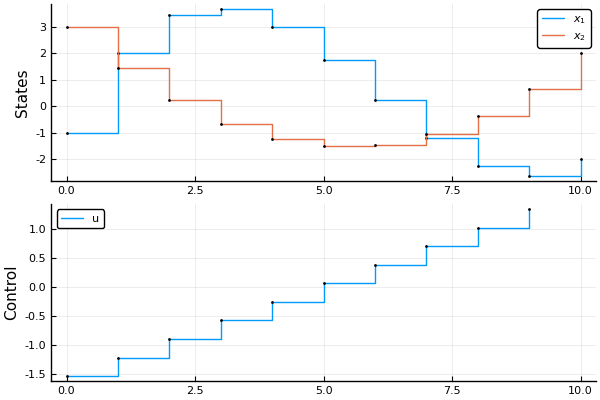

In [14]:
using Plots, LaTeXStrings
pyplot()

p1 = plot(0:N,x, label=[L"x_1" L"x_2"], ylabel="States",legend=:topright,markershape=:circ,markersize=1,linetype=:steppost)
p2 = plot(0:N-1,u, label="u", ylabel="Control",legend=:topleft,markershape=:circ,markersize=1,linetype=:steppost,xlims=xlims(p1))

plot(p1,p2,layout=(2,1))

## References

[1] Lewis, Frank, Draguna Vrabie, and Vassilis L. Syrmos. Optimal Control. 3rd edition. Hoboken: Wiley, 2012.

[2] Rawlings, James B., David Q. Mayne, and Moritz M. Diehl. Model Predictive Control: Theory, Computation, and Design. 2nd ed. Madison, Wisconsin: Nob Hill Publishing, LLC, 2017.